In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from os import walk
import seaborn as sns 
from matplotlib import rc
from sklearn import linear_model
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import IsolationForest

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 6,
          'font.size': 6,
          'legend.fontsize': 6,
          'text.usetex': True}

plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
#sns.axes_style()

In [2]:
path = '/Users/mayliscotadze/Documents/Safran/'
df = pd.read_csv(path + 'all_datas_cleaned.csv', sep=",", header=0, encoding="latin 1")
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'diff'], axis = 1)

Sur ce NOTEBOOK : 

    1) Détermination d'une catégorie 'vols typiques'
    
    2) Régression différenciée sur 3 phases sur ces vols typiques

# Détermination d'une catégorie "VOLS TYPIQUES"

### Utilisation algorithme de détection d'outliers

-> but : déterminer une catégorie "vols typiques" dans le dataset pour travailler notre modèle sur cette catégorie --> augmenter la précision du modèle

-> algorithme utilisé : Isolation forest car : 
    - dataset de grande dimension
    - pas d'hypothèse sur la distribution gaussienne des variables (cas de l'algorithme Elliptic Enveloppe)
    - on est dans le cas "outlier detection" (training data = normal and abnormal) et non "novelty detection" (One class SVM)

    ### Principe de l'algorithme Isolation forest

L'algorithme retourne un score d'anormalité pour chaque sample fourni. 
Pour chaque arbre de la forêt : 

Pour chaque noeud à partir de la racine, une variable (feature) est sélectionnée aléatoirement et les échantillons sont partionnés suivant une valeur prise aléatoirement entre le min et le max de cette feature. C'est itéré jusqu'à ce que l'échantillon soit isolé sur une des feuilles de l'arbre. 

Le nombre de partitionnements nécessaires pour isoler l'achantillon correspond à la longueur du chemin de l'arbre. Les différentes longueurs des arbres de la forêt sont moyennées = c'est la mesure d'anormalité pour l'échantillon = la fonction de décision de l'algorithme. 

Plus le chemin de la forêt est court, plus l'échantillon risque d'être anormal. 

## Sélection vols durée typique : 

     On commence par présélectionner les vols d'une durée typique avant d'appliquer l'algorithme sur cette pré
     sélection pour affiner la catégorie suivant les autres variables choisies

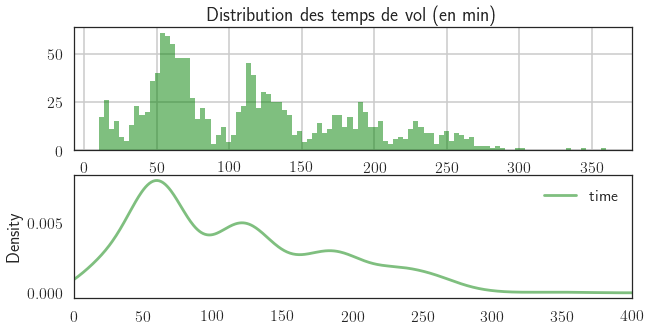

In [3]:
fig, axes = plt.subplots(2,1, figsize=(10,5))
df_flight_time = df.pivot_table(index = 'n_vol', values= 'time', aggfunc = lambda x: len(x)*2/60)

axes[0].set_title('Distribution des temps de vol (en min)')
df_flight_time.hist(bins = 100, color = 'green', alpha=0.5, ax = axes[0], label = 'a')
df_flight_time.plot.kde( color = 'green', alpha=0.5, ax = axes[1], xlim = [0, 400])
plt.legend(fontsize = 'small')

In [4]:
# Créons la catégorie : vols entre 40 et 80 min 
bins = [40, 80]
group_names = ['40-80']
cats = pd.cut(df_flight_time, bins = bins, labels = group_names)
pd.value_counts(cats)

40-80    465
Name: time, dtype: int64

In [5]:
index_flights_40_80 = cats[cats == '40-80'].index
df_flights_40_80 = df.set_index('n_vol').ix[index_flights_40_80]

## Sur ces vols à durée typique, détermination de la catégorie "vols typiques"

#### Extraction des variables caractéristiques

 - altitude moyenne
 - altitude max
 - altitude std empirique
 - outside temp moyenne
 - outside temp max
 - outside temp std
 - ground speed moyenne
 - ground speed max
 - ground speed std

In [6]:
liste_var = ['altitude', 'outside temp', 'ground speed']
mean = {var: df_flights_40_80.reset_index().pivot_table(index = 'n_vol', values= var, aggfunc = 'mean') for var in liste_var}
maxi = {var: df_flights_40_80.reset_index().pivot_table(index = 'n_vol', values= var, aggfunc = 'max') for var in liste_var}
std = {var: df_flights_40_80.reset_index().pivot_table(index = 'n_vol', values= var, aggfunc = 'std') for var in liste_var}

In [7]:
df_var_caract = pd.concat([mean['altitude'], maxi['altitude'], std['altitude'],
                           mean['outside temp'], maxi['outside temp'], std['outside temp'],
                           mean['ground speed'], maxi['ground speed'], std['ground speed']], axis = 1)

In [8]:
df_var_caract.columns = ['alt_mean', 'alt_max', 'alt_std', 'outsT_mean', 'outsT_max', 'outsT_std','grSpeed_mean', 'grSpeed_max', 'grSpeed_std']

In [9]:
df_var_caract.head()

,alt_mean,alt_max,alt_std,outsT_mean,outsT_max,outsT_std,grSpeed_mean,grSpeed_max,grSpeed_std
n_vol,,,,,,,,,
0001-6.csv,509.752030,1087.0,274.255664,25.412867,33,2.940036,153.695815,226.0,65.968121
0002-1.csv,505.841751,1125.0,325.742243,25.584736,32,3.305917,142.649270,244.0,77.909267
0002-2.csv,914.427337,2076.0,546.423087,23.049797,33,4.158839,171.905488,256.0,65.876502
0006-1.csv,527.700501,1130.0,349.640915,26.862782,36,3.587941,162.620927,248.0,82.137295
0006-6.csv,916.908273,1577.0,437.514075,22.413202,37,4.752524,150.516931,233.0,61.856535


## Utilisation algorithme IsolationForest

In [10]:
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0)

In [11]:
X_train = df_var_caract.values
outliers_pred = clf.fit(X_train).predict(X_train)

In [12]:
index_vols_typiques = df_var_caract[outliers_pred == 1].index

In [13]:
print("nombre de vols dans notre catégorie 'vols typiques' : {}".format(len(index_vols_typiques)))

nombre de vols dans notre catégorie 'vols typiques' : 418


In [14]:
df_vols_typiques = pd.DataFrame()
for flight in index_vols_typiques : 
    df_vols_typiques = pd.concat([df_vols_typiques, df_flights_40_80.ix[flight]])

In [58]:
df_vols_typiques.to_csv(path + 'df_vols_typique.csv')

In [15]:
df_vols_typiques.shape

(752583, 17)

##### Remarque : méthode possible pour déterminer ensuite si un vol est typique : on fit notre prédicteur sur un train bien choisi labélisé 'vols typiques' puis on prédit la typicité ou non du nouveau vol

# Regression Fuel Flow sur Torque sur la catégorie "vols typiques"

### Détermination des phases 01, 1 et 02

In [22]:
df_0 = df_vols_typiques[df_vols_typiques['phase'] == 0]
df_1 = df_vols_typiques[df_vols_typiques['phase'] == 1]

In [23]:
df_0.time = pd.to_datetime(df_0.time).values

//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [24]:
df_01 = pd.DataFrame()
df_02 = pd.DataFrame()

for f in np.unique(df_0.index):
    try:
        flight = df_0.ix[f]
        lim = df_0.ix[f][df_0.ix[f, 'time'].diff() > np.timedelta64(15, "m")]
        df_01 = pd.concat([df_01, flight.take(np.where(flight.time < lim.time.values[0])[0])])
        df_02 = pd.concat([df_02, flight.take(np.where(flight.time >= lim.time.values[0])[0])])
    except:
        pass

### Regression linéaire

In [41]:
def linear_regression(df):
    # Création du train et du test, on divise le set en 2 (environ 200 vols pour chaque)
    df_train = df.ix[np.unique(df.index)[::2]]
    df_test = df.ix[np.unique(df.index)[1::2]]
    
    X_train = df_train.ix[:, 'torque'].values.reshape(df_train.shape[0], 1)
    y_train = df_train.ix[:, 'fuel flow']
    X_test = df_test.ix[:, 'torque'].values.reshape(df_test.shape[0], 1)
    y_test = df_test.ix[:, 'fuel flow']
    
    regr = linear_model.LinearRegression().fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred = pd.Series(y_pred, index = y_test.index)
    beta = regr.coef_[0]
    
    res = y_test - y_pred
    # valeur moyenne des résidus sur le Test 
    mean_all_res = sum(res) / len(res)
    # Distribution des résidus moyens par vol
    mean_res_flight = res.reset_index().pivot_table(index = 'n_vol', values= 0, aggfunc = np.mean)
    return y_pred, res, beta, mean_all_res, mean_res_flight

In [44]:
y_pred01, res01, beta01, mean_all_res01, mean_res_flight01 = linear_regression(df_01)
y_pred02, res02, beta02, mean_all_res02, mean_res_flight02 = linear_regression(df_02)
y_pred1, res1, beta1, mean_all_res1, mean_res_flight1 = linear_regression(df_1)

###### Coefficients de regression par phase

In [46]:
print(" beta 01 : {}\n beta 1 : {}\n beta 02 : {}".format(beta01, beta1, beta02))

 beta 01 : 1.988507958425367
 beta 1 : 1.3634106048130585
 beta 02 : 1.7342323733334508


###### Valeur moyenne des résidus sur le test set (res = y_true - y_pred) par phase

In [47]:
print(" mean all res 01 : {}\n mean all res 1 : {}\n mean all res 02 : {}".format(mean_all_res01, mean_all_res1, mean_all_res02))

 mean all res 01 : -0.15564326375677567
 mean all res 1 : -0.05971155556297952
 mean all res 02 : -0.8277748409420256


     -> On remarque que res 02 > > res 01 > res 1

###### Distribution de la valeur moyenne des résidus par vol sur le test set pour les différentes phases

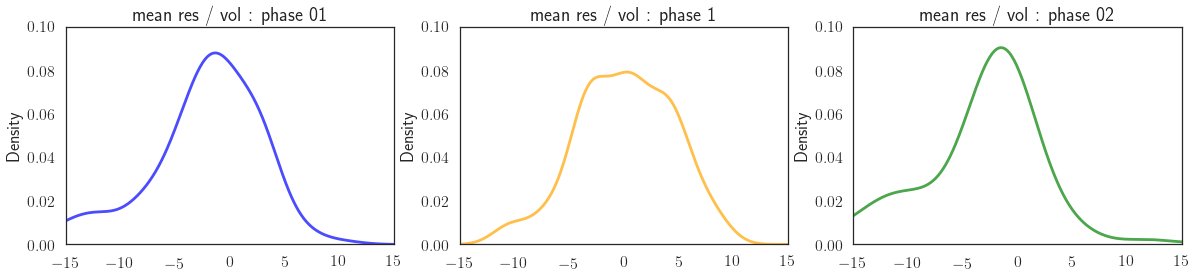

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
mean_res_flight01.plot.kde(color = 'blue', alpha=0.7, xlim = [-15,15], ylim = [0,0.1], ax = axes[0])
axes[0].set_title("mean res / vol : phase 01")
mean_res_flight1.plot.kde(color = 'orange', alpha=0.7, xlim = [-15,15], ylim = [0,0.1], ax = axes[1])
axes[1].set_title("mean res / vol : phase 1")
mean_res_flight02.plot.kde(color = 'green', alpha=0.7, xlim = [-15,15], ylim = [0,0.1], ax = axes[2])
axes[2].set_title("mean res / vol : phase 02")

        -> On remarque que la distribution des résidus en phase 1 est plus gaussienne
        -> Il y a une déportation vers le négatif pour les résidus en phases 01 et 02

###### Visualisation de Fuel flow, Torque et Résidus sur plusieurs des vols test pour les différentes phases

In [77]:
def plot_var_regr(df_test, res):
    df_plot = pd.DataFrame()
    df_plot['torque'] = df_test.ix[:, 'torque']
    df_plot['fuel flow'] = df_test.ix[:, 'fuel flow']
    df_plot['residus'] = res

    ncol = 3
    nrow = 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))
    k=30
    for i in range(nrow):
        for j in range(ncol):
            df_plot.ix[np.unique(df_plot.index)[k]].plot( use_index = False, ax=axes[i][j] , xticks = [], linewidth = 1.7, title = None)
            k += 1

def plot_res_sharey(res):
    df_plot = pd.DataFrame()
    df_plot['residus'] = res
    ncol = 3
    nrow = 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))
    k=30
    for i in range(nrow):
        for j in range(ncol):
            df_plot.residus.ix[np.unique(df_plot.index)[k]].plot( use_index = False, ax=axes[i][j] , ylim = [-50, 30], xticks = [], linewidth = 1.7, title = None)
            k += 1

def plot_res_non_sharey(res):
    df_plot = pd.DataFrame()
    df_plot['residus'] = res
    ncol = 3
    nrow = 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))
    k=30
    for i in range(nrow):
        for j in range(ncol):
            df_plot.residus.ix[np.unique(df_plot.index)[k]].plot( use_index = False, ax=axes[i][j], xticks = [], linewidth = 1.7, title = None)
            k += 1

In [70]:
df_test01 = df_01.ix[np.unique(df_01.index)[1::2]]
df_test02 = df_02.ix[np.unique(df_02.index)[1::2]]
df_test1 = df_1.ix[np.unique(df_1.index)[1::2]]

    ### PHASE 01

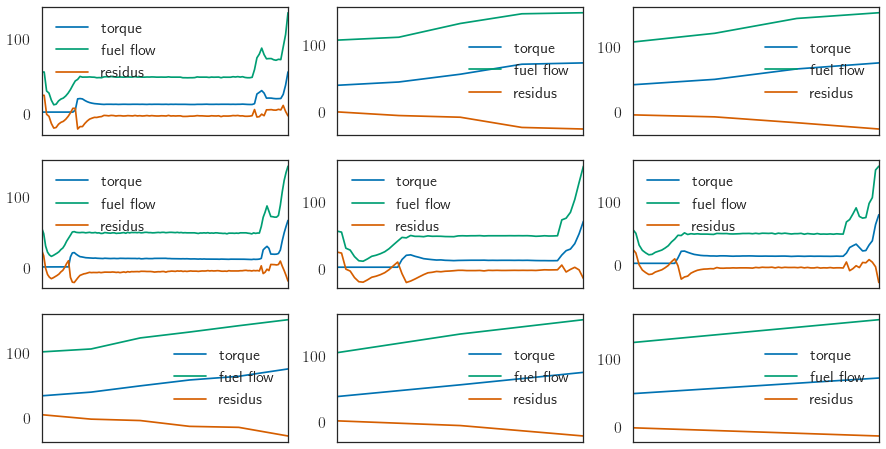

In [71]:
plot_var_regr(df_test01, res01)

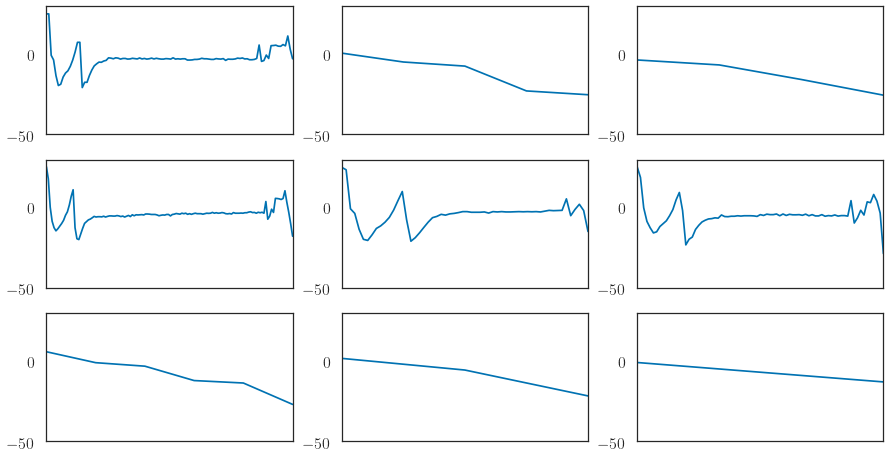

In [72]:
# Les mêmes valeurs pour axe y
plot_res_sharey(res01)

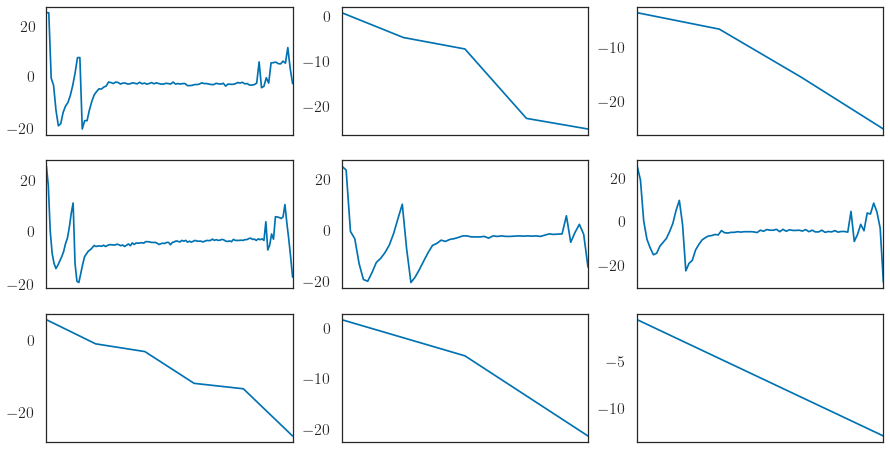

In [78]:
# plot avec ajustement de l'axe des y par plot
plot_res_non_sharey(res01)

    ### PHASE 1

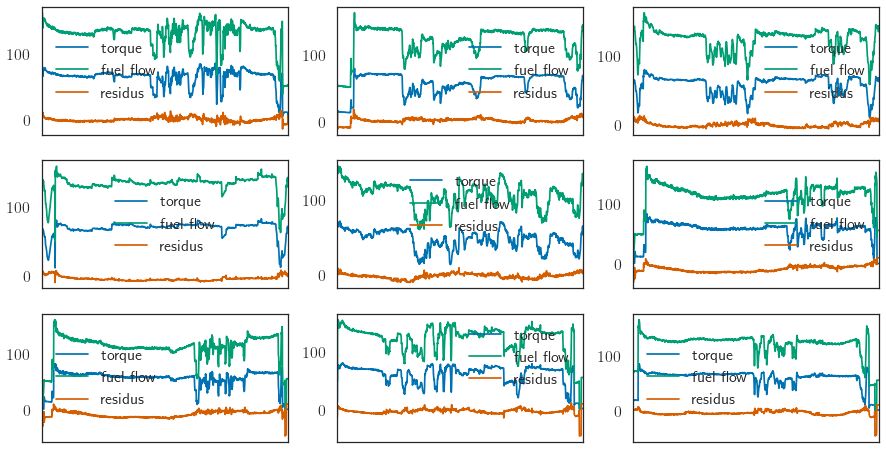

In [73]:
plot_var_regr(df_test1, res1)

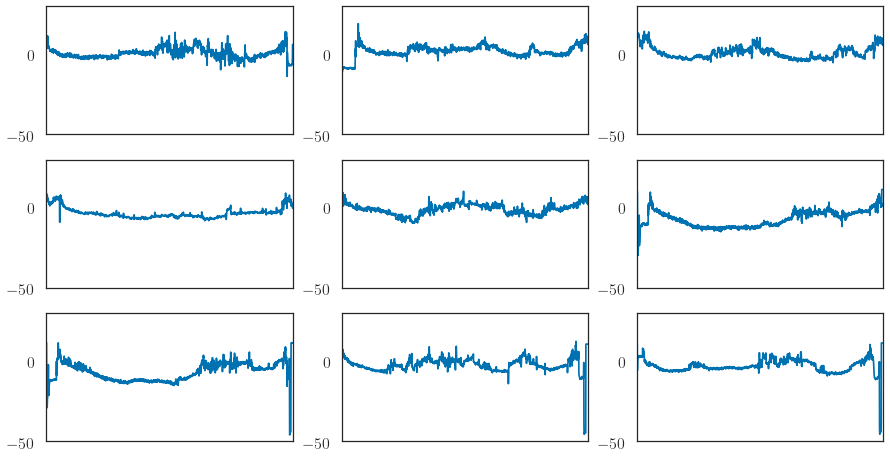

In [74]:
plot_res_sharey(res1)

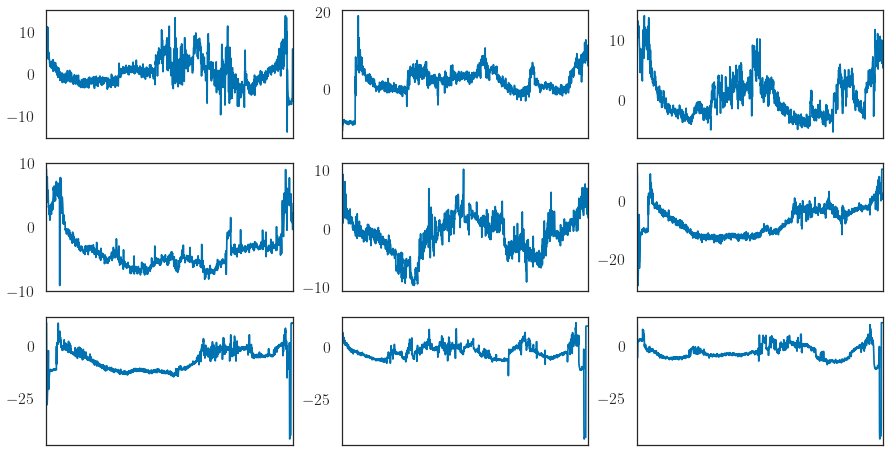

In [79]:
plot_res_non_sharey(res1)

     -> On remarque que le gros pic de résidus négatifs à la fin est présent soit en phase 0 (premiers plots) ou sur la phase 1 (cas des derniers plots)
     
     --> Il y a des similitudes sur les différents vols : pattern des résidus

        ### PHASE 02

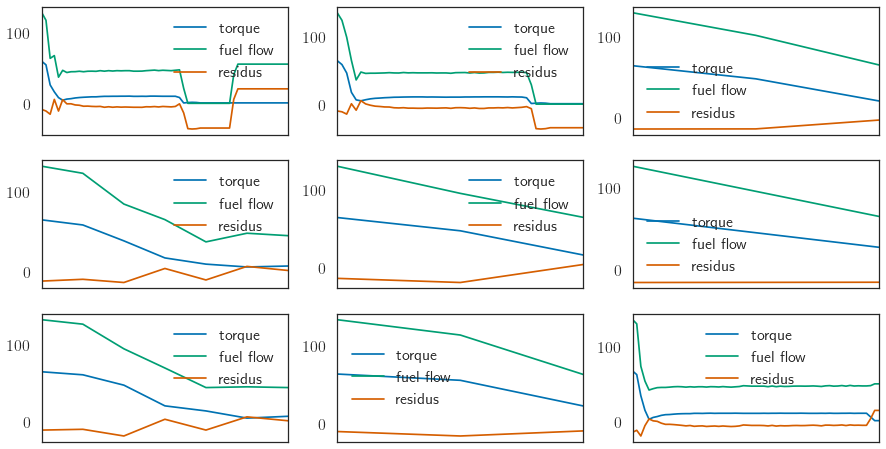

In [75]:
plot_var_regr(df_test02, res02)

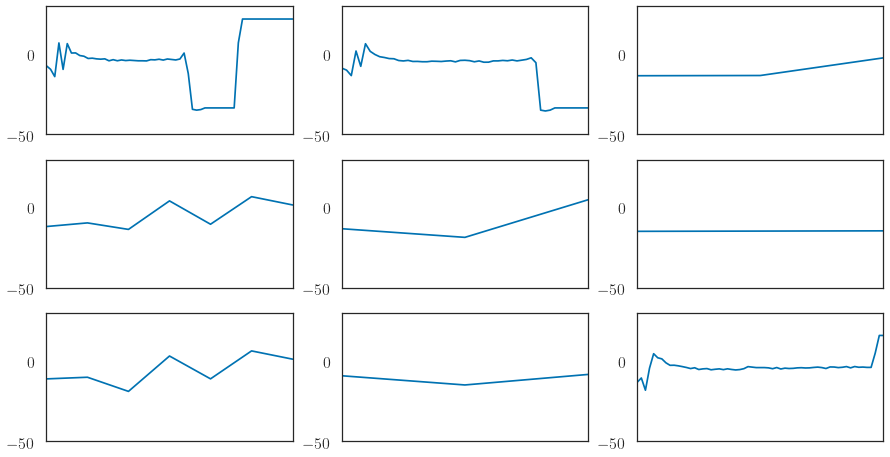

In [80]:
plot_res_sharey(res02)

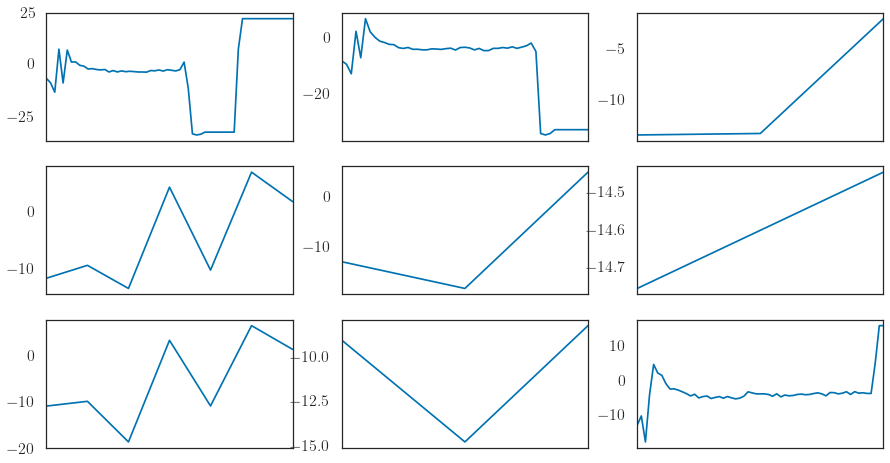

In [81]:
plot_res_non_sharey(res02)

        -> On remarque que les patterns sont très différents en fonction des vols sur cette phase 02

### Remarques sur ces plots

Les résidus sont différents selon les phases => 3 modèles différents avec des seuils ? Modèle également linéaire en phase 02 ?  

Le passage de phase 1 à phase 02 ne semble pas appropriée comme marqueur de changement de modèle (cf pics de résidus négatifs en fin de phase 1)

##### Autocorrelation des résidus

Le but : voir si le résidu à temps t est corrélé avec temps t-1 = si pattern précis, modèle à affiner
Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

In [83]:
res01.index

Index(['0002-1.csv', '0002-1.csv', '0002-1.csv', '0002-1.csv', '0002-1.csv',
       '0002-1.csv', '0002-1.csv', '0002-1.csv', '0002-1.csv', '0002-1.csv',
       ...
       '0566-2.csv', '0566-2.csv', '0566-2.csv', '0566-2.csv', '0566-2.csv',
       '0566-2.csv', '0566-2.csv', '0566-2.csv', '0566-2.csv', '0566-2.csv'],
      dtype='object', name='n_vol', length=18520)

In [84]:
from pandas.tools.plotting import autocorrelation_plot

def plot_autocorr(res):
    ncol = 3
    nrow = 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))
    k=30
    for i in range(nrow):
        for j in range(ncol):
            autocorrelation_plot(res.ix[np.unique(res.index)[k]], ax = axes[i][j])
            k += 1

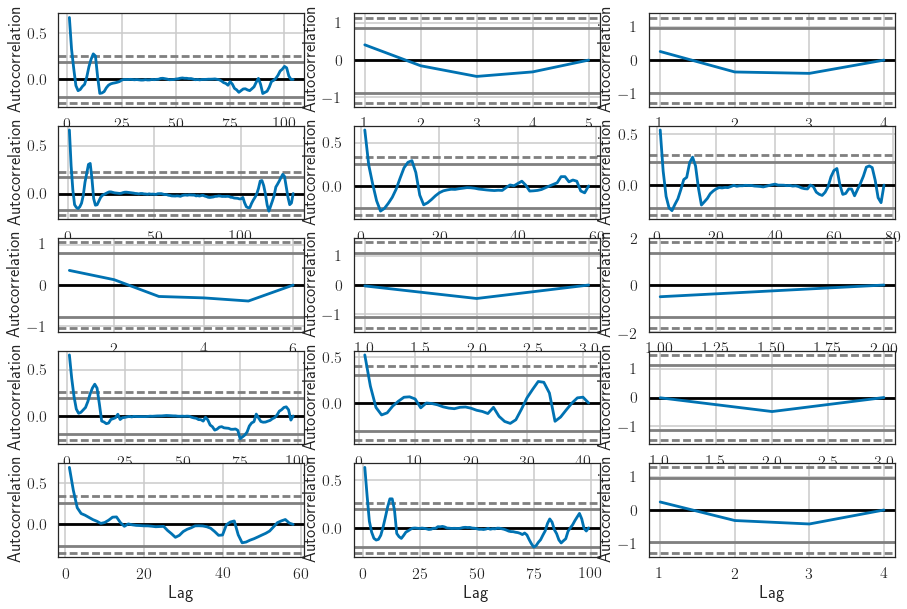

In [85]:
plot_autocorr(res01)

        -> On remarque que l'autocorrélation des résidus 01 reste dans l'intervalle de confiance (sauf au tout début)

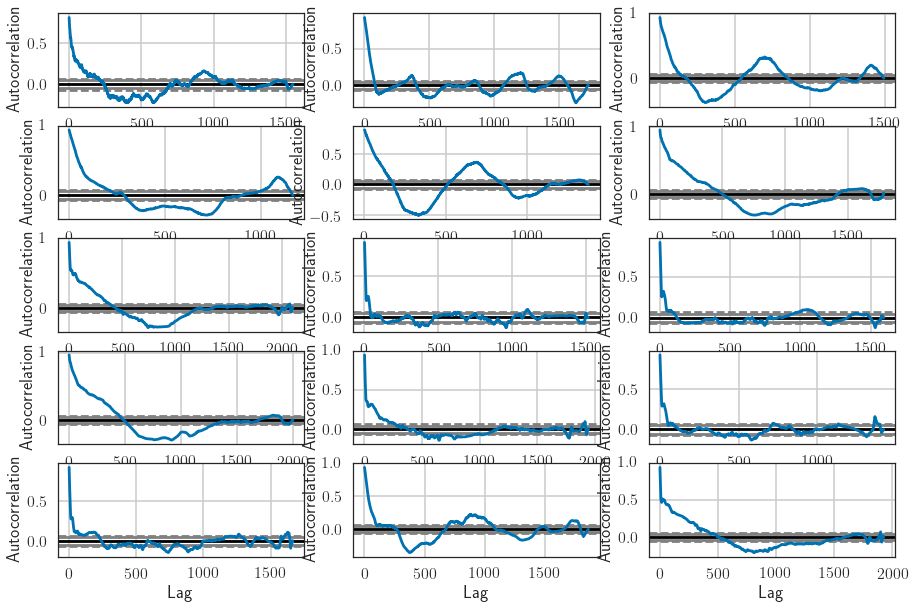

In [86]:
plot_autocorr(res1)

    -> On reamrque que l'autocorrelation sort de l'intervalle en particulier pour les lag 500 - 1000 : dépendance des résidus dans le temps

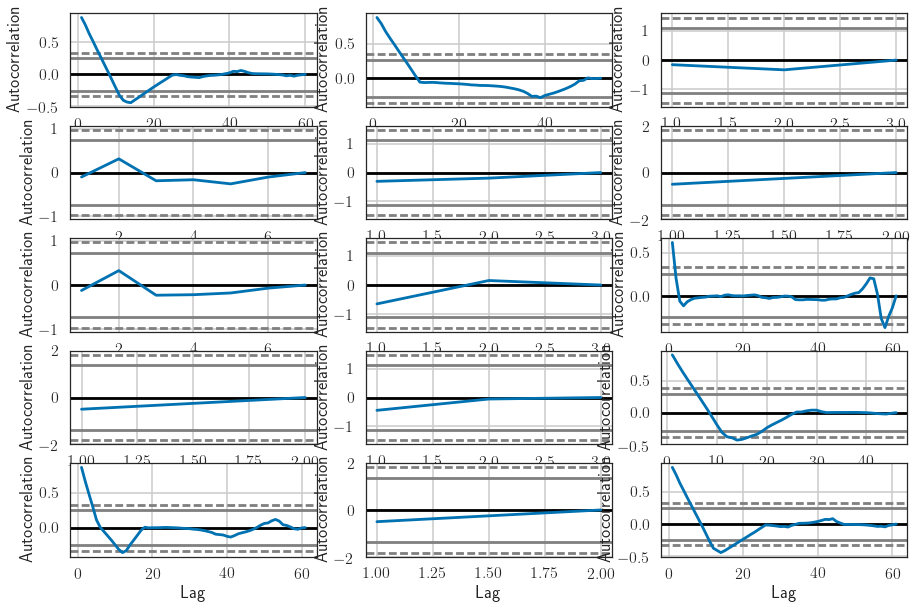

In [88]:
plot_autocorr(res02)

        -> en phase 02 également, l'autocorrélation reste dans l'intervalle de confiance : pas de dépendance entre résidus dans le temps